## Logistic Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import sklearn.linear_model as skl_lm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

### Loading the dataset

In [2]:
train_data = pd.read_csv('data/training_data_fall2024.csv')

# Transform label into 0 (low_bike_demand) and 1 (high_bike_demand)
train_data['increase_stock'] = np.where(train_data['increase_stock'] == 'low_bike_demand', 0, 1)

X = train_data.copy()
y = X.pop('increase_stock')

cat_features = ['hour_of_day', 'day_of_week', 'month', 'holiday', 'weekday', 'summertime']

### Split data into training and test sets

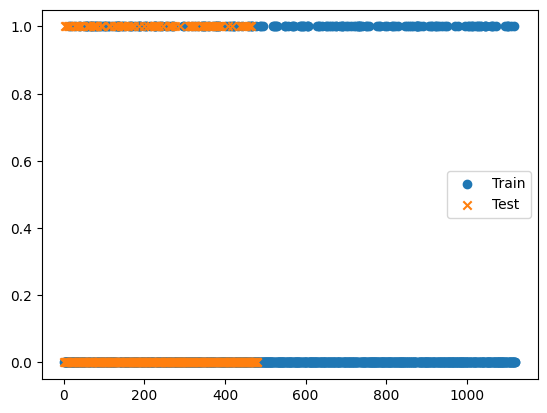

In [3]:
# Split the data into test (0.8) and train (0.3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Check if train and test data are balanced
plt.scatter(np.arange(1, len(y_train) + 1), y_train, marker='o', label='Train')
plt.scatter(np.arange(1, len(y_test) + 1), y_test, marker='x', label='Test')
plt.legend()
plt.show()

### Defining Logistic Regression function

We evaluate the model on precision because misclassifying high_bike_demand as low_bike_demand is more critical than the reverse. Predicting low_bike_demand during high_bike_demand results in not having enough bikes available for all the users, whereas overestimating demand simply leads to surplus bikes, which is less disruptive for users.

In [4]:
# Logistic Regression model with one-hot encoding
def logistic_regression(X, y, valid_size=0.2, cat_features=None):
    # One-hot encode categorical features
    X = pd.get_dummies(X, columns=cat_features)

    # Split the data into test (0.8) and train (0.2)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=valid_size, random_state=0)

    # Load and fit the model
    logr_model = skl_lm.LogisticRegression(max_iter=5000)
    logr_model.fit(X_train, y_train)

    # Compute predictions
    y_pred = logr_model.predict(X_valid)

    # Compute the metrics
    accuracy = accuracy_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred) # Proportion of 'low_bike_demand' (0) that were correctly predicted
    recall = recall_score(y_valid, y_pred) # Proportion of 'high_bike_demand' (1) that were correctly predicted
    conf_matrix = confusion_matrix(y_valid, y_pred)

    print(f"Logistic Regression Model \n")
    print(f"Accuracy: {round(accuracy, 4)}")
    print(f'Precision: {round(precision, 4)}')
    print(f'Recall: {round(recall, 4)}')
    print(f'Confusion Matrix: \n{conf_matrix}')

In [5]:
logistic_regression(X_train, y_train, valid_size=0.3, cat_features=cat_features)

Logistic Regression Model 

Accuracy: 0.875
Precision: 0.7414
Recall: 0.6143
Confusion Matrix: 
[[251  15]
 [ 27  43]]


### Tuning the model

In [6]:
def grid_search(X, y, valid_size=0.2, cat_features=None):
    # One-hot encode categorical features
    X = pd.get_dummies(X, columns=cat_features)

    # Split the data into test and train
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=valid_size, random_state=0)

    # Define the hyperparameter grid
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
        'penalty': ['l1', 'l2'],       # Regularization type
        'solver': ['liblinear', 'saga'] # Solver options compatible with L1/L2
    }

    # Load the model
    logr_model = skl_lm.LogisticRegression()

    # Perform grid search
    grid_search = GridSearchCV(logr_model, param_grid, cv=5, scoring='recall', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Compute predictions
    y_pred = grid_search.predict(X_valid)

    # Compute the metrics
    accuracy = accuracy_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred) # Proportion of 'low_bike_demand' (0) predictions that were correct
    recall = recall_score(y_valid, y_pred) # Proportion of 'high_bike_demand' (1) predictions that were correct
    conf_matrix = confusion_matrix(y_valid, y_pred)

    print(f"Logistic Regression Model \n")
    print(f"Accuracy: {round(accuracy, 4)}")
    print(f'Precision: {round(precision, 4)}')
    print(f'Recall: {round(recall, 4)}')
    print(f'Confusion Matrix: \n                low_bike_demand  high_bike_demand \nPredict low_bike_demand {conf_matrix[0]} \nPredict high_bike_demand {conf_matrix[1]}')

    return grid_search.best_estimator_

In [7]:
grid_search(X_train, y_train, valid_size=0.3, cat_features=cat_features)

Logistic Regression Model 

Accuracy: 0.872
Precision: 0.6957
Recall: 0.6857
Confusion Matrix: 
                low_bike_demand  high_bike_demand 
Predict low_bike_demand [245  21] 
Predict high_bike_demand [22 48]


LogisticRegression(C=100, penalty='l1', solver='liblinear')

## Trying pre-processed dataset

In [8]:
train_data = pd.read_csv('data/preprocessed_dataset.csv')

# Transform label into 0 (low_bike_demand) and 1 (high_bike_demand)
train_data['increase_stock'] = np.where(train_data['increase_stock'] == 'low_bike_demand', 0, 1)

X = train_data.copy()
y = X.pop('increase_stock')

cat_features = ['hour_of_day', 'day_of_week', 'month', 'weekday', 'summertime', 'snowdepth', 'day', 'rain']

In [9]:
# Split the data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [10]:
logistic_regression(X_train, y_train, valid_size=0.3, cat_features=cat_features)

Logistic Regression Model 

Accuracy: 0.8839
Precision: 0.7541
Recall: 0.6571
Confusion Matrix: 
[[251  15]
 [ 24  46]]


### Tuning the model

In [11]:
logreg_tuned = grid_search(X_train, y_train, valid_size=0.3, cat_features=cat_features)

Logistic Regression Model 

Accuracy: 0.881
Precision: 0.7206
Recall: 0.7
Confusion Matrix: 
                low_bike_demand  high_bike_demand 
Predict low_bike_demand [247  19] 
Predict high_bike_demand [21 49]


### Model cross validation

In [12]:
# Error rate evaluation of the model through cross validation
def model_cv(X, y, cat_features, n_fold):
    #missclassification = {}
    recalls = {}
    
    # One-hot encode categorical features
    X = pd.get_dummies(X, columns=cat_features)

    # Defining the cv strategy
    kf = KFold(n_splits=n_fold, random_state=0, shuffle=True)

    # Iterate through the K different folds
    for train_index, valid_index in kf.split(X):
        X_train = X.iloc[train_index]
        X_valid = X.iloc[valid_index]
        y_train = y.iloc[train_index]
        y_valid = y.iloc[valid_index]

        # Load and fit the model
        model = skl_lm.LogisticRegression(max_iter=5000)
        model.fit(X_train, y_train)
        
        # Compute predictions
        y_pred = model.predict(X_valid)

        # Compute the recall
        #error = np.sum(y_pred != y_valid) / y_valid.shape[0]
        #missclassification.setdefault(str(model), []).append(error)
        recall = recall_score(y_valid, y_pred)
        recalls.setdefault(str(model), []).append(recall)

    print("Average recall:")
    for key in recalls:
        print(f"  {key}: {np.mean(recalls[key]):.2f}")

    # Plot boxplot
    plt.boxplot(recalls.values())
    plt.xticks(range(1, 2), ['logReg'])
    plt.ylabel('recall')
    plt.title('Cross validation recall')
    plt.show()

Average recall:
  LogisticRegression(max_iter=5000): 0.65


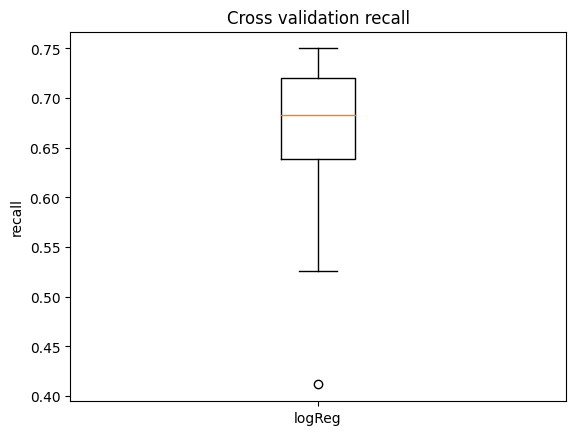

In [13]:
model_cv(X_train, y_train, cat_features, n_fold=10)

## Final Evaluation

### Define the evaluation function

In [14]:
def evaluate_model(X_test, y_test, model, cat_features):
    # One-hot encode categorical features
    X_test = pd.get_dummies(X_test, columns=cat_features)

    # Compute predictions with the model already trained
    y_pred = model.predict(X_test)

    # Compute the metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred) # Proportion of 'low_bike_demand' (0) predictions that were correct
    recall = recall_score(y_test, y_pred) # Proportion of 'high_bike_demand' (1) predictions that were correct
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"Logistic Regression Model \n")
    print(f"Accuracy: {round(accuracy, 4)}")
    print(f'Precision: {round(precision, 4)}')
    print(f'Recall: {round(recall, 4)}')
    print(f'Confusion Matrix: \n                low_bike_demand  high_bike_demand \nPredict low_bike_demand {conf_matrix[0]} \nPredict high_bike_demand {conf_matrix[1]}')

### Use the optimal model

In [15]:
evaluate_model(X_test, y_test, model=logreg_tuned, cat_features=cat_features)

Logistic Regression Model 

Accuracy: 0.8583
Precision: 0.5976
Recall: 0.5833
Confusion Matrix: 
                low_bike_demand  high_bike_demand 
Predict low_bike_demand [363  33] 
Predict high_bike_demand [35 49]
